In [55]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1" #<- for the common server(SSH)

In [56]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
master_device = 'cuda' if torch.cuda.is_available() else 'cpu'
import numpy as np
from torch.utils.data import Subset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from typing import List
# import lovely_tensors as lt
# lt.monkey_patch()

In [57]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [58]:
# TODO for testing purpose, remove later!!!!
trainset = Subset(trainset, list(range(5000)))

In [59]:
def count_model_params(model):
    return  sum(p.numel() for p in model.parameters())

In [60]:
base_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
base_model.fc = nn.Linear(512, 10)
base_loss = nn.CrossEntropyLoss(reduction='sum')

In [61]:
count_model_params(base_model)

11181642

In [62]:
num_workers = 5
worker_dataset_size = len(trainset) // num_workers
batch_size = 64
batch_size_worker_dataset = 256 #
K = 10**6
gamma = 1e-3
VR_used = True
TRAIN_SET_SIZE = len(trainset)

# W = D / K - 1 (D - num of params)
W = count_model_params(base_model) / K - 1

if VR_used:
    p = min(
        1.0 / (1 + W), batch_size_worker_dataset / (batch_size_worker_dataset + worker_dataset_size)
    )  # TODO reimplemented, may be incorrect
else:
    p = 1.0/(1+W)

TEST_LEN = 500
rand_list = np.random.randint(low=0, high=len(trainset), size=TEST_LEN)
testloader = DataLoader(Subset(trainset, rand_list))

In [63]:
class WorkerModel:
    def __init__(
        self, model_name, dataset, VR=False, batch_size_worker_dataset=256
    ) -> None:
        if model_name == "ResNet18":
            self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
            self.model.fc = nn.Linear(512, 10)
        else:
            raise NotImplementedError("This model is not implemented")

        self.dataset = dataset
        self.dataloader = DataLoader(dataset, batch_size=batch_size)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.batch_size_worker_dataset = batch_size_worker_dataset
        self.model = self.model.to(self.device)
        self.VR = VR
        self.D = count_model_params(self.model)
        self.K = K

    def full_grad(self):
        self.mean_by_trainset = torch.tensor(1 / TRAIN_SET_SIZE).to(self.device)

        self.model.train()
        for batch in tqdm(self.dataloader):
            inputs, labels = batch
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            outputs = self.model(inputs)
            loss = self.mean_by_trainset * F.cross_entropy(outputs, labels, reduction='sum')
            loss.backward()

        result = []
        for param in self.model.parameters():
            result.append(param.grad.data.detach().clone())
            param.grad = None
        return result

    def substarct_grads(self, g_prev, g_next):
        g_result = []
        assert len(g_prev) == len(g_next)
        for i in range(len(g_prev)):
            g_result.append(g_next[i] - g_prev[i])
        return g_result

    def add_grads(self, grad1, grad2):
        g_result = []
        assert len(grad1) == len(grad2)
        for i in range(len(grad1)):
            g_result.append(grad1[i] + grad2[i])
        return g_result

    def compress_vector(self, v):
        """Vector compression with RandK algo"""
        S = torch.randperm(self.D)
        S = S[0 : self.K]
        out = torch.zeros_like(v)
        out[S] = self.D / self.K * v[S]
        return out

    def MARINA_step(self, gk, ck):
        self.mean_by_batch = (
            torch.Tensor([1.0 / (self.batch_size_worker_dataset)]).to(self.device)
            if self.VR
            else self.mean_by_trainset
        )
        self.mean_by_trainset = torch.tensor(1 / TRAIN_SET_SIZE).to(self.device)

        if ck == 1:
            k = 0
            for p in self.model.parameters():
                p.data = p.data - gamma * gk[k]
                k = k + 1

            self.model.train()
            for batch in self.dataloader:
                inputs, labels = batch
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.mean_by_trainset * F.cross_entropy(outputs, labels, reduction='sum')
                loss.backward()

            result = []
            for param in self.model.parameters():
                result.append(param.grad.data.detach().clone())
                param.grad = None
            return result

        elif ck == 0:
            if self.VR:
                indicies = torch.randperm(len(self.dataset))[
                    0 : self.batch_size_worker_dataset
                ]
                subset = torch.utils.data.Subset(self.dataset, indicies)
            else:
                subset = self.dataset

            minibatch_loader = DataLoader(subset, batch_size=batch_size)

            self.model.train()
            for batch in minibatch_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.mean_by_batch * F.cross_entropy(outputs, labels, reduction='sum')
                loss.backward()

            g_batch_prev = []
            for p in self.model.parameters():
                g_batch_prev.append(p.grad.data.detach().clone())
                p.grad = None

            k = 0
            for p in self.model.parameters():
                p.data = p.data - gamma * gk[k]
                k = k + 1

            for batch in minibatch_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.mean_by_batch * F.cross_entropy(outputs, labels, reduction='sum')
                loss.backward()

            g_batch_next = []
            for p in self.model.parameters():
                g_batch_next.append(p.grad.data.detach().clone())
                p.grad = None

            g_delta = self.substarct_grads(g_batch_prev, g_batch_next)

            # ===============================================================================================
            """
            Convert gradient defference to the flatten form of 1D vector
            To compress it with RandK compressor and the turn it back to the initial form
            """
            delta_offset = 0
            g_delta_flatten = torch.zeros(self.D).to(self.device)

            for t in range(len(g_delta)):
                offset = len(g_delta[t].flatten(0))
                g_delta_flatten[(delta_offset) : (delta_offset + offset)] = g_delta[
                    t
                ].flatten(0)
                delta_offset += offset

            g_delta_flatten = self.compress_vector(g_delta_flatten)

            delta_offset = 0
            for t in range(len(g_delta)):
                offset = len(g_delta[t].flatten(0))
                g_delta[t].flatten(0)[:] = g_delta_flatten[
                    (delta_offset) : (delta_offset + offset)
                ]
                delta_offset += offset
            # ===============================================================================================

            g_resulting = self.add_grads(gk, g_delta)
            return g_resulting

In [64]:
datasets = []
for i in range(num_workers):
    start_idx = i * worker_dataset_size
    end_idx = (i + 1) * worker_dataset_size

    # Create a Subset of the dataset for the current part
    subset = Subset(trainset, list(range(start_idx, end_idx)))
    datasets.append(subset)

In [65]:
def take_full_grad(workers):
    """
    Initial step of the MARINA Algorithm
    calculate full gradient on all the workers
    to get the first value of g
    """
    workers_full_grad = []
    for worker in workers:
        workers_full_grad.append(worker.full_grad()) # calculate on all the workers
    g0 = workers_full_grad[0]
    for i in range(1, num_workers): # summing up all the gradients from the client of the master node
        for j in range(len(workers_full_grad[i])):
            g0[j] = g0[j] + workers_full_grad[i][j].to(master_device)
    gk = list(map(lambda x: 1/num_workers * x, g0)) # take mean of g after summing up from all workers
    return gk

In [66]:
def take_MARINA_step(workers: List[WorkerModel], gk):
    step_grads = []
    for worker in workers:
        rand_num = np.random.random()
        ck = 1 if rand_num < p else 0

        step_grads.append(worker.MARINA_step(gk, ck))

    total_grad = step_grads[0]
    for i in range(1, len(step_grads)):
        for j in range(len(step_grads[i])):
            total_grad[j] = total_grad[j] + step_grads[i][j].to(master_device)

    total_grad = list(map(lambda x: 1/num_workers * x, total_grad))
    return total_grad

In [67]:
def getAccuracy(model, dataloader, device):
    avg_accuracy = 0

    model.eval()
    for inputs, outputs in dataloader:
        inputs, outputs = inputs.to(device), outputs.to(device)                  # move to device
        logits = model(inputs)                                                   # forward-pass: Make a forward pass through the network
        avg_accuracy += (logits.data.argmax(1) == outputs).sum().item()

    avg_accuracy /= TEST_LEN
    model.train()

    return avg_accuracy

def getLossAndGradNorm(model, dataloader, device):
    total_loss = 0
    grad_norm = 0
    one_inv_samples = torch.Tensor([1.0/TEST_LEN]).to(device)

    model.eval()
    for p in model.parameters():
        p.grad = None

    for inputs, outputs in dataloader:
        inputs, outputs = inputs.to(device), outputs.to(device)                             # move to device

        logits = model(inputs)

        loss = one_inv_samples * F.cross_entropy(logits, outputs, reduction='sum')          # compute objective
        loss.backward()                                                                     # compute the gradient (backward-pass)
        total_loss += loss

    for p in model.parameters():
        grad_norm += torch.norm(p.grad.data.flatten(0))**2
        p.grad = None

    model.train()
    return total_loss, grad_norm

In [68]:
def eval_model(model, trainloader):
    acc = getAccuracy(model, trainloader, device=master_device)
    loss, grad_norm = getLossAndGradNorm(model, trainloader, device=master_device)
    return acc, loss, grad_norm

In [69]:
accs = []
losses = []
grad_norms = []

In [70]:
import logging
logging.basicConfig(filename='MARINA-1000Iters.log', level=logging.INFO)

In [71]:
def train_loop(MAX_ITER):
    workers = []
    for i in range(num_workers):
        curr_worker = WorkerModel('ResNet18', datasets[i], VR=VR_used)
        workers.append(curr_worker)
        print(f"Worker {i+1} on device - {curr_worker.device}")
    print("==================Taking full gradient as first step==================")
    gk = take_full_grad(workers)
    print('========================Starting MARINA steps=========================')
    for i in tqdm(range(MAX_ITER-1)):
        if i%10 == 0:
            acc, loss, g_norm = eval_model(workers[0].model, testloader)
            accs.append(acc)
            losses.append(loss.item())
            grad_norms.append(g_norm.item())
            print(f"Step={i+1}, accuracy={acc}, loss={loss.item()}, gradient_norm={g_norm}")
            logging.info(f"Step={i+1}, accuracy={acc}, loss={loss.item()}, gradient_norm={g_norm}")
            # accs_np = np.array(accs)
            # losses_np = np.array(losses)
            # grad_norms_np = np.array(grad_norms)
            # np.save('no_vr_accs.npy', accs_np)
            # np.save('no_vr_losses.npy', losses_np)
            # np.save('no_vr_grad_norms.npy', grad_norms_np)
        gk_next = take_MARINA_step(workers, gk)
        gk = gk_next

In [72]:
MAX_ITER = 2500
train_loop(MAX_ITER)

Worker 1 on device - cuda
Worker 2 on device - cuda
Worker 3 on device - cuda
Worker 4 on device - cuda
Worker 5 on device - cuda
==================Taking full gradient as first step==================


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

========================Starting MARINA steps=========================


  0%|          | 0/2499 [00:00<?, ?it/s]

Step=1, accuracy=0.094, loss=2.4187819957733154, gradient_norm=13.732355117797852
Step=11, accuracy=0.106, loss=2.6338002681732178, gradient_norm=123.46015167236328
Step=21, accuracy=0.108, loss=2.6461358070373535, gradient_norm=110.2783203125
Step=31, accuracy=0.106, loss=2.6153135299682617, gradient_norm=117.86164093017578
Step=41, accuracy=0.112, loss=2.6055421829223633, gradient_norm=123.98627471923828
Step=51, accuracy=0.106, loss=2.6096091270446777, gradient_norm=123.91548156738281
Step=61, accuracy=0.116, loss=2.605438232421875, gradient_norm=119.4603271484375
Step=71, accuracy=0.114, loss=2.570636749267578, gradient_norm=98.48695373535156
Step=81, accuracy=0.108, loss=2.588923692703247, gradient_norm=111.5507583618164


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (50,) and (9,)

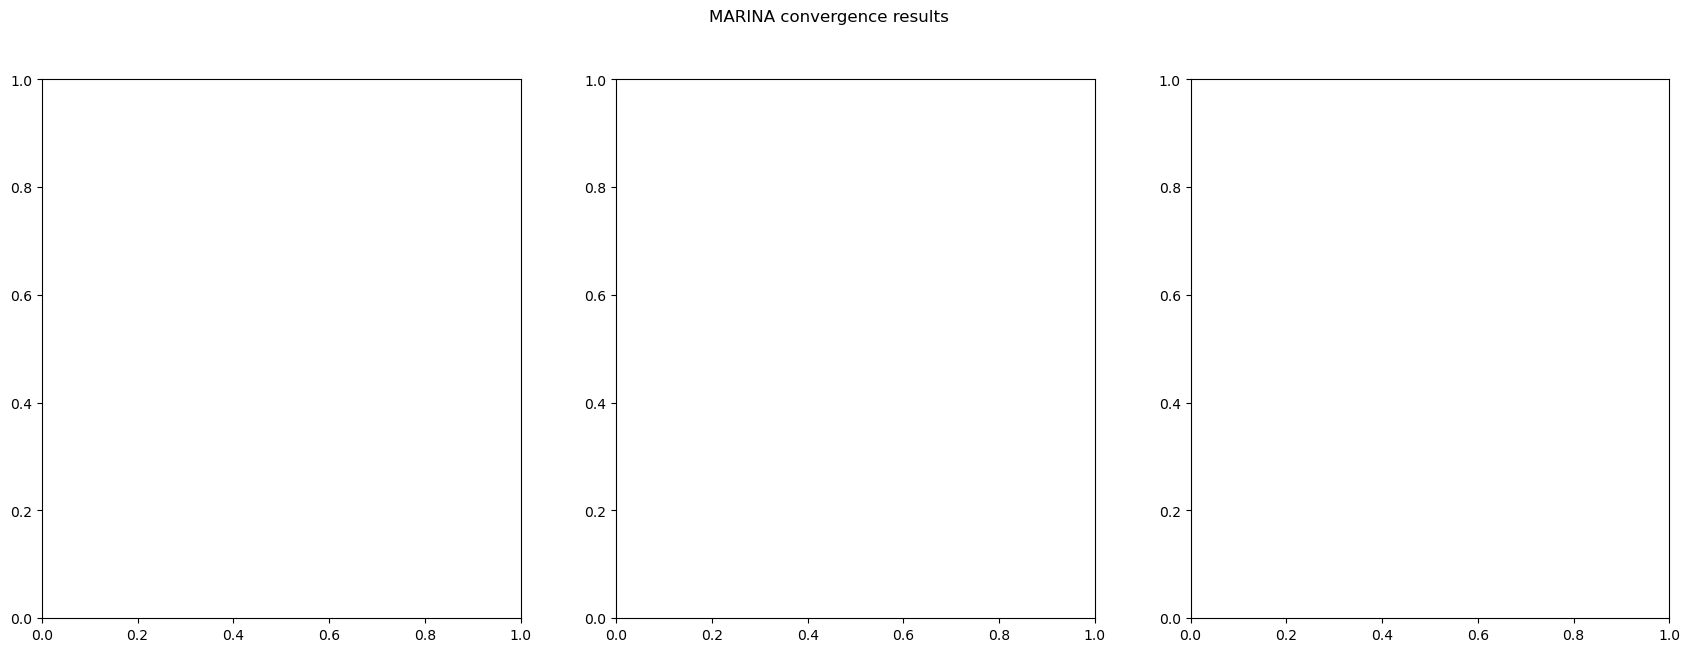

In [73]:
fig, ax = plt.subplots(1, 3,  figsize=(21, 7))
fig.suptitle('MARINA convergence results')
X = np.arange(2500, step=50)

ax[0].plot(X, accs)
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Accuaracy')

ax[1].plot(X, losses)
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Loss')

ax[2].plot(X, grad_norms)
ax[2].set_ylabel("$\| \\nabla f(x)\|^2$")
ax[2].set_xlabel('Step')

ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.savefig('marina_convergence.png')